In [1]:
import random
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from math import floor
from itertools import combinations
from collections import defaultdict
from networkx import NetworkXException
from networkx.algorithms.approximation import steiner_tree

<div class="alert alert-block alert-info">
<b>🌌Graph:</b> fidelity-aware distribution of a 3-qubit GHZ state
using site-bond percolation to model the underlying quantum network.
</div>

_Initialize the Graph_

In [3]:
def build_initial_grid(w, h):
    G = nx.Graph()
    for i in range(w):
        for j in range(h):
            G.add_node((i, j))
            parity = (i + j) % 2
            for dx in [-1, 1]:
                ni = i + dx
                if 0 <= ni < w:
                    G.add_edge((i, j), (ni, j))
            if parity == 0 and j + 1 < h:
                G.add_edge((i, j), (i, j + 1))
            elif parity == 1 and j - 1 >= 0:
                G.add_edge((i, j), (i, j - 1))
    return G

_site-bond percolation_

In [4]:
def percolate_graph(G, w, h, p, q, p_f, terminals):
    Gp = G.copy()
    # Bond 
    for edge in list(Gp.edges):
        if random.random() > p:
            Gp.remove_edge(*edge)
        else:
            if random.random() < p_f:
                Gp.edges[edge]['fidelity'] = 1.0
            else:
                Gp.edges[edge]['fidelity'] = random.uniform(0.9, 1.0)
    # Site 
    for component in nx.connected_components(Gp):
        if terminals <= component:
            surviving_nodes = set()
            for node in component:
                if node in terminals or random.random() <= q:
                    surviving_nodes.add(node)
            return Gp.subgraph(surviving_nodes).copy()
    return None
# ---------------------------------------------------------------------------------------------------------
# calculate the tree
def compute_steiner_tree(G, terminals, weight='fidelity'):
    comp = nx.node_connected_component(G, next(iter(terminals)))
    if terminals <= comp:
        return steiner_tree(G.subgraph(comp).copy(), terminals, weight=weight, method="kou")
    return None

_fidelity of the chain_

In [5]:
def compute_fidelity_along_path(G, path):
    fidelity = G[path[0]][path[1]].get("fidelity", 1.0)
    for i in range(1, len(path) - 1):
        f_next = G[path[i]][path[i + 1]].get("fidelity", 1.0)
        fidelity = fidelity * f_next + ((1 - fidelity) * (1 - f_next)) / 3
    return fidelity
def analyze_steiner_tree_fidelity(Gp, T, terminals):
    candidates = [n for n in T if T.degree[n] == max(dict(T.degree()).values())]
    center = next((n for n in candidates if n in terminals), candidates[0])
    #print(f"Center node: {center}")
    fidelity_dict = {}
    for terminal in terminals:
        if terminal != center:
            path = nx.shortest_path(T, center, terminal)
            fidelity = compute_fidelity_along_path(Gp, path)
            fidelity_dict[terminal] = fidelity
        else:
            fidelity_dict[center] = 1.0
    return fidelity_dict
# ---------------------------------------------------------------------------------------------------------
# final fidelity
def compute_final_fidelity(F1, F2, F3):
    eps1 = (1 - F1) / 3
    eps2 = (1 - F2) / 3
    eps3 = (1 - F3) / 3
    e1 = eps1 + eps2 + eps3
    e2 = eps1 * eps2 + eps1 * eps3 + eps2 * eps3
    e3 = eps1 * eps2 * eps3
    F4 = 1 - 3 * e1 + 10 * e2 - 32 * e3
    return F4

📉_Visualize_

In [6]:
def visualize_parity_grid_with_abc(G, w, h, T=None, scale=0.8):
    pos = { (i, j): (scale * i, -scale * j) for (i, j) in G.nodes }

    A = (1, 1)
    B = (w - 2, h - 2)
    C = (w - 2, 1)

    terminals = {A, B, C}
    special_nodes = [n for n in terminals if n in G]
    regular_nodes = [n for n in G.nodes if n not in special_nodes]

    fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

    # Draw regular nodes
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_color='#4F8FC0', node_size=100, ax=ax)

    # Draw special nodes with different colors
    if A in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[A], node_color='#62A87C', node_size=200, ax=ax)
    if B in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[B], node_color='#7EE081', node_size=200, ax=ax)
    if C in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[C], node_color='#C3F3C0', node_size=200, ax=ax)

    # Draw base graph edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.0, ax=ax)

    # Draw Steiner tree if provided
    if T is not None and len(T.edges) > 0:
        nx.draw_networkx_edges(T, pos, edge_color='black', width=2.5, ax=ax)

    # Add labels for A, B, C if present
    labels = {n: lbl for n, lbl in zip([A, B, C], ['A', 'B', 'C']) if n in G}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black', ax=ax)

    ax.set_title("Parity Grid with A, B, C + Steiner Tree")
    ax.axis('off')
    plt.show()

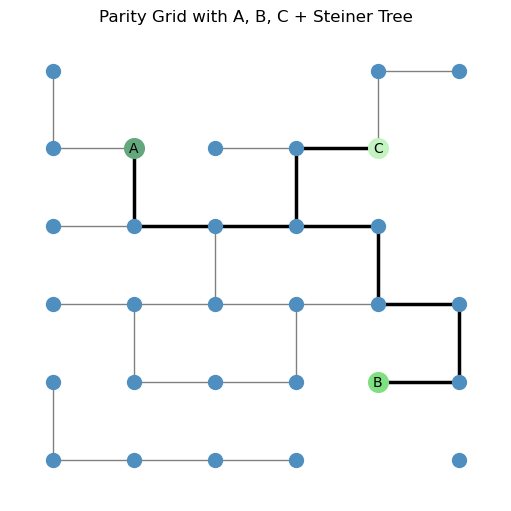

fidelity dictionary: {(4, 4): 1.0, (1, 1): 0.9998304277355478, (4, 1): 1.0}
Final GHZ fidelity is: 0.9998304277355478


In [9]:
p = 0.85
q = 0.90
p_f = 0.80
w = 6
h = 6
A = (1, 1)
B = (w - 2, h - 2)
C = (w - 2, 1)
terminals = {A, B, C}
# ---------------------------------------------------------------------------------------------------------
G = build_initial_grid(w, h)
Gp = percolate_graph(G, w, h, p, q, p_f, terminals)
T = compute_steiner_tree(Gp, terminals)
visualize_parity_grid_with_abc(Gp, w, h, T=T)
if T != None:
    fidelity_dict = analyze_steiner_tree_fidelity(Gp, T, terminals)
    F_vals = [fidelity_dict[t] for t in terminals]
    fidelity_ghz = compute_final_fidelity(*F_vals)
    print(f"fidelity dictionary: {fidelity_dict}")
    print(f"Final GHZ fidelity is: {fidelity_ghz}")
else:
    print("❌ No valid Steiner tree exists.")

<div class="alert alert-block alert-info">
<b>📡Hypergraph:</b> fidelity-aware distribution of a 3-qubit GHZ state
using site-bond percolation to model the underlying quantum network.
</div>

_Initialize the Hypergraph_

In [10]:
def build_hypergraph(w, h):
    G1 = build_initial_grid(w, h)
# ---------------------------------------------------------------------------------------------------------
    # potential bug: unwanted nodes are added at parity check 
    G2 = nx.Graph()
    factor_node_list = set()
    for i in range(w):
        for j in range(h):
            parity = (i + j) % 2
            if parity == 1: # parity 1 are the base nodes 
                G2.add_node((i, j))
                if j + 1 < h and i + 2 < w:
                    G2.add_edge((i + 1, j), (i, j))
                    G2.add_edge((i + 1, j), (i + 1, j + 1))
                    G2.add_edge((i + 1, j), (i + 2, j))
                    factor_node_list.add((i + 1, j))
    hyperg = [G1, G2]
    return [hyperg, factor_node_list]

_Multiplex hypergraph Percolation_

In [11]:
def percolate_graph(hyperg, factor_node_list, p, q, p_f, terminals):
    G1 = hyperg[0].copy()
    G2 = hyperg[1].copy()

    # ---------------------------------------------------------------------------------------------------------
    # Bond percolation on G1 edges with fidelity
    for edge in list(G1.edges):
        if random.random() > p:
            G1.remove_edge(*edge)
        else:
            G1.edges[edge]['fidelity'] = 1.0 if random.random() <= p_f else random.uniform(0.9, 1.0)

    # ---------------------------------------------------------------------------------------------------------
    # Hyperedge percolation: remove factor nodes probabilistically
    # Note that here G2 is not updated
    factor_node_list = [node for node in factor_node_list if random.random() <= p]
    for node in factor_node_list:
        G2.nodes[node]['fidelity'] = 1.0 if random.random() <= p_f else random.uniform(0.9, 1.0)

    # ---------------------------------------------------------------------------------------------------------
    # Site percolation: keep nodes with probability q or if they are terminals
    survived1 = {node for node in G1.nodes if node in terminals or random.random() <= q}
    
    # Update G1
    G1 = G1.subgraph(survived1).copy()
    
    # Keep base nodes that survived and are also in G2
    survived2 = set(G2.nodes) & (survived1 | set(factor_node_list))
    G2 = G2.subgraph(survived2).copy() # G2 is updated

    # Filter out factor nodes with degree less than number of terminals
    factor_node_up = [node for node in factor_node_list if node in G2 and G2.degree[node] == len(terminals)]
    invalid_factors = set(factor_node_list) - set(factor_node_up)
    G2.remove_nodes_from(invalid_factors)

    return [G1, G2, factor_node_up]

Procesing . . .

In [ ]:
def factor_2_base_node(factor_node):
    """
    Given a factor node coordinate (i, j),
    return the list of its three base nodes.
    """
    i, j = factor_node
    alpha_1 = (i - 1, j)
    alpha_2 = (i + 1, j)
    alpha_3 = (i + 1, j + 1)
    
    return {alpha_1, alpha_2, alpha_3}

In [ ]:
def can_expand_hyperedge(G1, F1, F2, F3):
    """
    a,b in F1; c,d in F2; e,f in F3
    True if paths a~c, d~e, f~b in G1.
    """
    F1 = tuple(F1); F2 = tuple(F2); F3 = tuple(F3)

    # Precompute reachability from the 9 candidates to avoid repeated BFS
    candidates = set(F1) | set(F2) | set(F3)
    reach = {u: set(nx.single_source_shortest_path_length(G1, u).keys()) for u in candidates}

    # Try all ordered pairs (no mutation, no randomness needed)
    for a, b in itertools.permutations(F1, 2):
        for c, d in itertools.permutations(F2, 2):
            for e, f in itertools.permutations(F3, 2):
                if (c in reach[a]) and (e in reach[d]) and (b in reach[f]):
                    return True
    return False

In [ ]:
# define w and h, p, q, p_f, and the set of terminals 
[hyperg, factor_node_list] = build_hypergraph(w, h) # first you initialize the hypergraph 
[G1, G2, factor_node_up] = percolate_graph(hyperg, factor_node_list, p, q, p_f, terminals) # percolation process 
    
'''
1. get the factor node lists
2. create the set of all combinations of three factor node 
3. choose a member call F1, F2, F3
4. use factor_2_base_node to get the list of each base nodes 
5. see if the three factor nodes are connected 
    if yes:
    5.1.1 add those three to the dictionary 
    5.1.2. remove the elementary hyperedges from the dictionary
    5.1.3. calculate the fidelity of the new hyperedge using the graph 
    5.1.4. all fidelity to the dictionary 
    if no:
    5.2.1. go to 3. choose another set of three factor nodes 
6. now look at the remaining elementary hyperedges at the dictionary
7. add their fidelity using the graph 
'''
